In [1]:
from collections import defaultdict

import numpy as np
import pandas as pd
from scipy.spatial.distance import jensenshannon

In [2]:
p = 0.40
k = 2.1
gamma = 1.28

In [3]:
home_pdf = pd.read_pickle('../../data/derived/before/home_pdf.pkl')
sequence_length = np.load('../../data/derived/before/sequence_length.npy', allow_pickle=True)

In [4]:
grid_to_hotspot_level = pd.read_pickle('../../data/derived/before/hotspot_level_by_grid.pkl')
hotspot_level_to_grid = defaultdict(list)
for k_, v_ in grid_to_hotspot_level.items():
    hotspot_level_to_grid[v_].append(k_)

In [5]:
homes = list(home_pdf.keys())
homes_p = [home_pdf[home] for home in homes]

In [6]:
d = pd.read_pickle('../../data/derived/before/distance.pkl')

In [7]:
from collections import Counter, defaultdict

import numpy as np
from scipy.stats import entropy


def generate_sequence(
    p, gamma, k, generated_homes, sequence_length, hotspot_level_to_grid, d,
):
    distribution = np.array([1 / np.power(i + 1, k) for i in range(10)])
    distribution /= sum(distribution)

    generated_sequences = []
    for home, length in zip(generated_homes, sequence_length):
        next_grids = [home]
        for i in range(length - 1):
            if np.random.random() < p:
                next_grid = np.random.choice(next_grids)
            else:
                level = np.random.choice(np.arange(10), p=distribution) + 1
                c = Counter(next_grids)
                m = max(c.values())
                home = np.random.choice([key for key in c if c[key] == m])
                next_grid = get_next_grid(home, gamma, d, hotspot_level_to_grid[level])
            next_grids.append(next_grid)
        generated_sequences.append(next_grids)

    return generated_sequences

def get_next_grid(home, gamma, d, target_grids):
    target_grids = [spot for spot in target_grids if spot != home]
    weight = np.array([1 / np.power(d[home][spot], gamma) for spot in target_grids])
    weight = weight / sum(weight)

    return target_grids[np.random.choice(np.arange(len(target_grids)), p=weight)]

In [8]:
generated_homes_idx = np.random.choice(
        np.arange(len(homes)), size=len(sequence_length), replace=True, p=homes_p
)

In [9]:
generated_homes = [homes[idx] for idx in generated_homes_idx]

In [10]:
generated_sequences = generate_sequence(
        p, gamma, k, generated_homes, sequence_length, hotspot_level_to_grid, d,
)

In [11]:
from collections import Counter, defaultdict

home_list = []
ratio_list = []
for row in generated_sequences:
    counter_dict = dict(Counter(row))
    max_val = max(counter_dict.values())
    max_keys = [k for k, v in counter_dict.items() if v == max_val]
    home = max_keys[np.random.choice(len(max_keys))]
    home_list.append(home)
    ratio_list.append(max_val/len(row))


In [12]:
length_list = np.array(list(map(len, generated_sequences)))

In [13]:
ratio_list = np.array(ratio_list)

In [14]:
from matplotlib import cm, figure, font_manager

INPUT_FONT_FILE = '../../assets/Helvetica.ttf'
prop = font_manager.FontProperties(fname=INPUT_FONT_FILE, size=22)
small_prop = font_manager.FontProperties(fname=INPUT_FONT_FILE, size=18)

In [15]:
sequences = np.load('../../data/derived/before/sequence.npy', allow_pickle=True)
vendor_to_grid = pd.read_pickle('../../data/derived/before/vendor_to_grid.pkl')
sequences = np.array([list(map(vendor_to_grid.get, row)) for row in sequences])

from collections import Counter, defaultdict
length_list_data = []
ratio_list_data = []
for row in sequences:
    counter_dict = dict(Counter(row))
    max_val = max(counter_dict.values())
    max_keys = [k for k, v in counter_dict.items() if v == max_val]
    home = max_keys[np.random.choice(len(max_keys))]
    ratio_list_data.append(max_val/len(row))
    length_list_data.append(len(row))


/home/balla/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


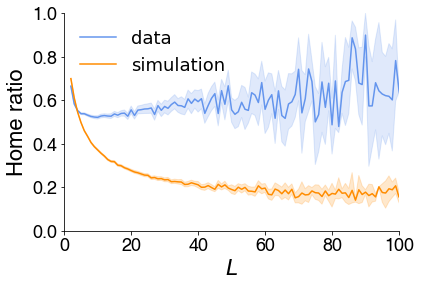

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.DataFrame({
    'ratio': ratio_list,
    'length': length_list
})
df_ = pd.DataFrame({
    'ratio': ratio_list_data,
    'length': length_list_data
})
ax = sns.lineplot(x="length", y="ratio",
             data=df_,  color='cornflowerblue', label='data')
ax = sns.lineplot(x="length", y="ratio",
             data=df, label='simulation', color='darkorange',)
for label in ax.get_yticklabels():
    label.set_fontproperties(small_prop)
for label in ax.get_xticklabels():
     label.set_fontproperties(small_prop)
ax.set_xlabel(r'$L$', fontproperties=prop)
ax.set_ylabel('Home ratio',fontproperties=prop)
ax.set_xlim([0,100])
ax.set_ylim([0,1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(fontsize=18, frameon=False)
plt.savefig('figs/home_ratio_wo_loyalty.pdf', bbox_inches='tight')

In [18]:
def calculate_entropy(given_sequences, grid_to_hotspot_level, hotspot_level=10):
    entropy_array = []
    for row in given_sequences:
        hotspot_row = list(map(grid_to_hotspot_level.get, row))
        temp_vec = np.zeros(hotspot_level)
        temp_dict = dict(Counter(hotspot_row))
        temp_sum = sum(temp_dict.values())
        for k, v in temp_dict.items():
            temp_vec[int(k - 1)] = v / temp_sum
        entropy_array.append(entropy(temp_vec))
    entropy_array = np.array(entropy_array)

    return entropy_array


def calculate_locational_variance(given_sequences, d):
    var_array = []
    for row in given_sequences:
        counter_dict = dict(Counter(row))
        max_val = max(counter_dict.values())
        max_keys = [k for k, v in counter_dict.items() if v == max_val]
        home = max_keys[np.random.choice(len(max_keys))]
        var = 0
        for k, v in counter_dict.items():
            if k != home:
                var += (d[home][k] ** 2) * v
        var /= len(row)
        var_array.append(np.sqrt(var))

    return var_array

In [19]:
entropies = calculate_entropy(generated_sequences, grid_to_hotspot_level)
variances = calculate_locational_variance(generated_sequences, d)

In [20]:
def get_pdf(points, bins):
    temp_counter = Counter(np.digitize(points, bins))
    temp_sum = sum(temp_counter.values())
    temp_ys = [temp_counter.get(i, 0) / temp_sum for i in range(1, len(bins))]

    return temp_ys

from collections import Counter 

entropy_data = np.load('../../data/derived/before/entropy_data.npy')
variance_data = np.load('../../data/derived/before/varaince_data.npy')

ent_bins = np.linspace(0, 2.1, 30 + 1)
var_bins = np.linspace(0, 18, 30 + 1)
ent_xs = [(ent_bins[i] + ent_bins[i + 1])/2 for i in range(len(ent_bins) - 1)]
var_xs = [(var_bins[i] + var_bins[i + 1])/2 for i in range(len(var_bins) - 1)]

ent_data_pdf = get_pdf(entropy_data, ent_bins)
var_data_pdf = get_pdf(variance_data, var_bins)

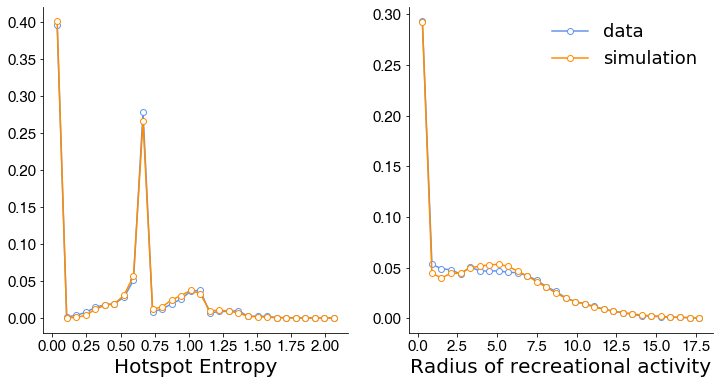

In [21]:
from scipy.spatial.distance import jensenshannon
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
font_path = '../../assets/Helvetica.ttf'


ent_sim_pdf = get_pdf(entropies, ent_bins)
var_sim_pdf = get_pdf(variances, var_bins)
    
plt.rcParams['figure.figsize'] = (12.0, 6.0)

prop = font_manager.FontProperties(fname=font_path, size=22)
small_prop = font_manager.FontProperties(fname=font_path, size=18)
tiny_prop = font_manager.FontProperties(fname=font_path, size=15)

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(ent_xs, ent_data_pdf, '-o', markerfacecolor='white', color='cornflowerblue', label='data')
ax1.plot(ent_xs, ent_sim_pdf, '-o', markerfacecolor='white', color='darkorange', label='simulation')
ax1.set_xlabel('Hotspot Entropy', fontsize=20)

ax2.plot(var_xs, var_data_pdf, '-o', markerfacecolor='white', color='cornflowerblue', label='data')
ax2.plot(var_xs, var_sim_pdf, '-o', markerfacecolor='white', color='darkorange',label='simulation')
ax2.set_xlabel('Radius of recreational activity',fontsize=20)

plt.legend(fontsize=18, frameon=False)

for label in ax1.get_xticklabels():
    label.set_fontproperties(tiny_prop)
for label in ax1.get_yticklabels():
    label.set_fontproperties(tiny_prop)
for label in ax2.get_xticklabels():
    label.set_fontproperties(tiny_prop)
for label in ax2.get_yticklabels():
    label.set_fontproperties(tiny_prop)
ent_jsd = jensenshannon(ent_data_pdf, ent_sim_pdf)
var_jsd = jensenshannon(var_data_pdf , var_sim_pdf)


ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)


plt.savefig('figs/beofer_best_model_wo_loyalty.pdf', bbox_inches='tight')